# Import Libraries/Packages & Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

In [2]:
#load data
import os
attackdata = {}
os.chdir('idsattacks')
for i in os.listdir():
  attackdata[i] = pd.read_csv(i)
  attackdata[i].drop(['Label', 'Dst Port', 'Timestamp', 'Flow Byts/s', 'Flow Pkts/s'], axis=1, inplace=True)


In [3]:
bendata = pd.read_csv('D:/Amrita College/OneDrive - Amrita university/Semester 7/Codes/Final Year Project/Benign.csv')

In [4]:
#checking for unwanted columns
for i in attackdata:
  for j in ['Flow ID', 'Src IP', 'Src Port', 'Dst IP']:
    if j in attackdata[i].columns:
      print(i + " : " + j)
#attackdata[i].drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1, inplace=True)

In [5]:
for i in ['Flow ID', 'Src IP', 'Src Port', 'Dst IP']:
    if i in bendata.columns:
      print('bendata' + " : " + i)
bendata.drop(['Label'],axis=1,inplace=True)

In [6]:
#scaling data for normalizing
scaler = StandardScaler()
for i in attackdata:
  attackdata[i] = scaler.fit_transform(attackdata[i])

In [7]:
bendata = scaler.fit_transform(bendata)

In [8]:
bendata

array([[ 0.00000000e+00, -4.27641239e-02, -4.44035915e-01, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02],
       [ 0.00000000e+00, -3.90753907e-02, -4.44035915e-01, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02],
       [ 0.00000000e+00, -4.36484005e-02, -4.44035915e-01, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02],
       ...,
       [ 0.00000000e+00, -4.38297579e-02,  2.16678503e+00, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02],
       [ 0.00000000e+00, -4.39329660e-02,  2.16678503e+00, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02],
       [ 0.00000000e+00, -4.37138081e-02, -4.44035915e-01, ...,
        -1.16983915e-03, -3.20578776e-02, -3.20401698e-02]])

In [9]:
#printing the shapes of the data
for i in attackdata:
  print(i + " : " + str(attackdata[i].shape))

Bot.csv : (286191, 75)
Brute Force -Web.csv : (611, 75)
Brute Force -XSS.csv : (230, 75)
DDOS attack-HOIC.csv : (686012, 75)
DDOS attack-LOIC-UDP.csv : (1730, 75)
DDoS attacks-LOIC-HTTP.csv : (576191, 75)
DoS attacks-GoldenEye.csv : (41508, 75)
DoS attacks-Hulk.csv : (461912, 75)
DoS attacks-SlowHTTPTest.csv : (139890, 75)
DoS attacks-Slowloris.csv : (10990, 75)
FTP-BruteForce.csv : (193354, 75)
Infilteration.csv : (160739, 75)
SQL Injection.csv : (87, 75)
SSH-Bruteforce.csv : (187589, 75)


In [10]:
print('bendata' + " : " + str(bendata.shape))

bendata : (2457307, 75)


In [11]:
len(attackdata)

14

In [12]:
#loading data into pytorch dataloader as train and test
devices = []
batch_size = 128
train_loader = {}
test_loader = {}
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    train_loader[i] = torch.utils.data.DataLoader(attackdata[i][:int(attackdata[i].shape[0]*0.9)], batch_size = batch_size, shuffle=True)
    test_loader[i] = torch.utils.data.DataLoader(attackdata[i][int(attackdata[i].shape[0]*0.9):], batch_size = batch_size, shuffle=True)
    devices.append(i)

In [13]:
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    print(len(test_loader[i]))

224
536
451
361
110
152
126
147


In [14]:
ben_loader = torch.utils.data.DataLoader(bendata[int(bendata.shape[0]*0.9):], batch_size = batch_size, shuffle=True)

In [15]:
#initialising config variables
num_clients = len(train_loader)      # Number of clients
num_selected = len(train_loader)    # Typically, num_selected is around 30–40% of the num_clients.
#baseline_num = 1000  # choose some data from the train set to retrain the data from trained model
num_rounds = 5  #100      # Total number of communication rounds for the global model to train.
epochs = 10          # for train client model
retrain_epochs = 5  # Total number of retraining rounds on the global server after receiving the model weights
                      # from all the clients that participated in the communication round.

In [16]:
len(train_loader)

8

In [17]:
len(devices)

8

## FedAvg / FedAvgM

In [18]:
# aggregates the model weights received from every client
# and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()):
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias



In [19]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
          output = client_model(data.float()) # tensor 115
          optimizer.zero_grad()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(device), output)
          loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())


## Deep Auto-encoder Model

In [20]:
# Deep Auto-encoder model

input_dim = 75
class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        #self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc2 = nn.Linear(input_dim, 32)
        #self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 16)
        #self.bn3 = nn.BatchNorm1d(16)
        self.fc4 = nn.Linear(16, 8)
        #self.bn4 = nn.BatchNorm1d(8)
        self.fc5 = nn.Linear(8, 8)
        #self.bn5 = nn.BatchNorm1d(8)
        self.fc6 = nn.Linear(8, 16)
        #self.bn6 = nn.BatchNorm1d(16)
        self.fc7 = nn.Linear(16, 32)
        #self.bn7 = nn.BatchNorm1d(32)
        self.fc8 = nn.Linear(32, input_dim)
        #self.bn8 = nn.BatchNorm1d(input_dim)
        self.fc9 = nn.Linear(input_dim, input_dim)
        self.activation = nn.Tanh()

        # Initialize weights using He initialization with Tanh
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc5.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc6.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc7.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc8.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc9.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.activation(x)
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.activation(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        x = self.activation(x)
        x = self.fc4(x)
        #x = self.bn4(x)
        x = self.activation(x)
        x = self.fc5(x)
        #x = self.bn5(x)
        x = self.activation(x)
        x = self.fc6(x)
        #x = self.bn6(x)
        x = self.activation(x)
        x = self.fc7(x)
        #x = self.bn7(x)
        x = self.activation(x)
        x = self.fc8(x)
        #x = self.bn8(x)
        x = self.activation(x)
        x = self.fc9(x)
        return x

## Initialisation

In [21]:
# Initializing models and optimizer

global_model = AEModel(input_dim).to(device)
client_models = [AEModel(input_dim).to(device) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())

# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}
opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]
# lr_list = [0.012, 0.012, 0.012, 0.00005]
# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]

# Training Federated Model

In [ ]:
# Train Client Model and Global Model
train_loss_client = []
train_loss_global = []
train_loss_per_client = [[] for i in range(num_clients)]

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    #client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    client_idx = list(range(num_clients))
    print('client_idx: ',client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] # Need to fix this. It is part of server aggregation.
    # client_lens = [len(train_lotrain_loaderader[idx]) for idx in client_idx ]
    print(client_lens)


    #### client update ####
    loss = 0
    for i in tqdm(range(num_selected)):
        # print(i)
        client_syn(client_models[i], global_model)
        # print(train_loader[devices[client_idx[i]]])
        l = client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
        train_loss_per_client[i].append(l)
        loss += l
    train_loss_client.append(loss)


    #### retraining on the global server ####
    #loss_retrain = 0
    #for i in tqdm(range(num_selected)):
    #    loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    #train_loss_global.append(loss_retrain/num_selected)


    ### aggregate models ###
    #server_aggregate(global_model, client_models, client_lens)      # FedAvg
    server_aggregate_M(global_model, client_models, client_lens)    # FedAvgM

    print("\nclient_loss: ", loss)
    #print('global_loss: ', loss_retrain/num_selected)

time_required = time.time() - start_time
print('\nTIME: {}mins'.format(time_required/60))


round:  1
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7]
[2013, 4824, 4052, 3248, 984, 1360, 1131, 1319]


100%|██████████| 8/8 [14:52<00:00, 111.60s/it]



client_loss:  0.5149892227686957

round:  2
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7]
[2013, 4824, 4052, 3248, 984, 1360, 1131, 1319]


100%|██████████| 8/8 [16:25<00:00, 123.22s/it]



client_loss:  2.6059840349835777

round:  3
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7]
[2013, 4824, 4052, 3248, 984, 1360, 1131, 1319]


100%|██████████| 8/8 [17:15<00:00, 129.39s/it]



client_loss:  2.6062055512984865

round:  4
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7]
[2013, 4824, 4052, 3248, 984, 1360, 1131, 1319]


100%|██████████| 8/8 [17:27<00:00, 130.89s/it]



client_loss:  2.6060779229820135

round:  5
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7]
[2013, 4824, 4052, 3248, 984, 1360, 1131, 1319]


100%|██████████| 8/8 [17:31<00:00, 131.41s/it]


client_loss:  2.606077468735202

TIME: 83.53864834705989mins


In [ ]:
# save model
torch.save(global_model,'D:/Amrita College/OneDrive - Amrita university/Semester 7/Codes/Final Year Project/models/globalattackmodel.pt')

In [ ]:
for i in range(len(train_loss_per_client)):
  print(train_loss_per_client[i])

[0.1810280597046463, 0.4605968728495213, 0.4606761066979251, 0.4606615936391586, 0.46069772833966594]
[0.005663310403987352, 0.28229014504435246, 0.2821098957581455, 0.2821043500750886, 0.282121001928118]
[0.0701986793545969, 0.36740732888681016, 0.36729088060186416, 0.3672583843723881, 0.36726808584472653]
[0.017418527064918067, 0.529624459397947, 0.5297696651051307, 0.5297821738293825, 0.5297796126349549]
[0.00015234906643898994, 0.07501505761657183, 0.07499181812371665, 0.0750066345459138, 0.07504159504381137]
[6.961452585301231e-05, 0.0700890996685142, 0.07007350206155988, 0.07006970969686176, 0.07006307789809345]
[0.2109948053007417, 0.7648295268719435, 0.7651583689382706, 0.7650693586239448, 0.7649742386754269]
[0.029463877347513323, 0.05613154464791768, 0.0561353140118743, 0.05612571819927586, 0.056132128370404696]


In [70]:
for i in range(len(devices)):
  torch.save(client_models[i],'D:/Amrita College/OneDrive - Amrita university/Semester 7/Codes/Final Year Project/models/clients/' + devices[i] + '.pt')

RuntimeError: Parent directory D:/Amrita College/OneDrive - Amrita university/Semester 7/Codes/Final Year Project/models/clients does not exist.

In [ ]:
def printperformance(model, losses, modelname):
    plt.plot(losses)
    plt.xlabel('number of rounds')
    plt.ylabel('loss')
    plt.ylim((0, 2.5))
    plt.grid()
    plt.title(modelname)
    plt.show()

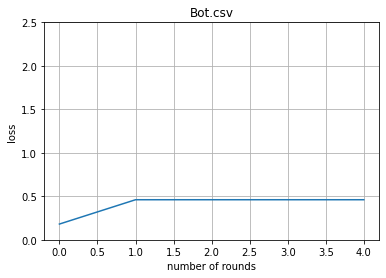

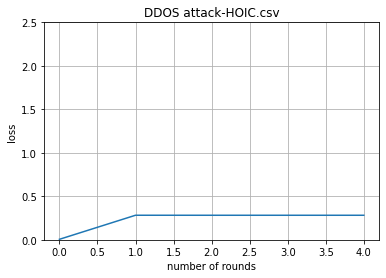

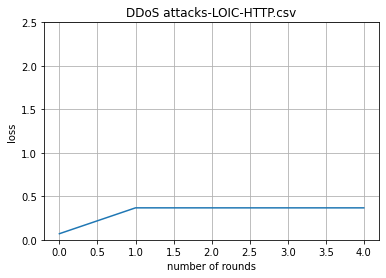

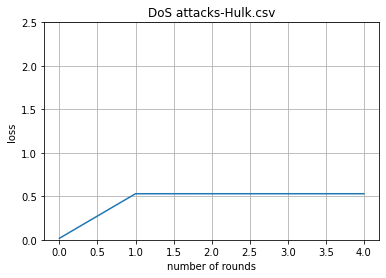

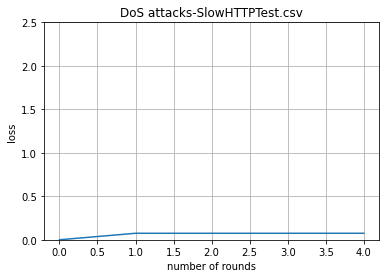

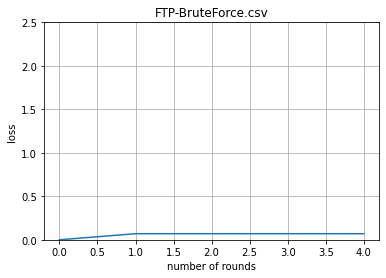

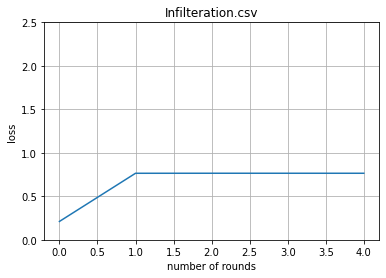

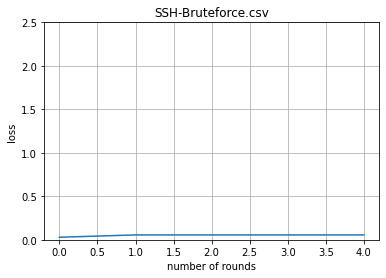

In [ ]:
for i in range(len(devices)):
  printperformance(client_models[i], train_loss_per_client[i], devices[i])

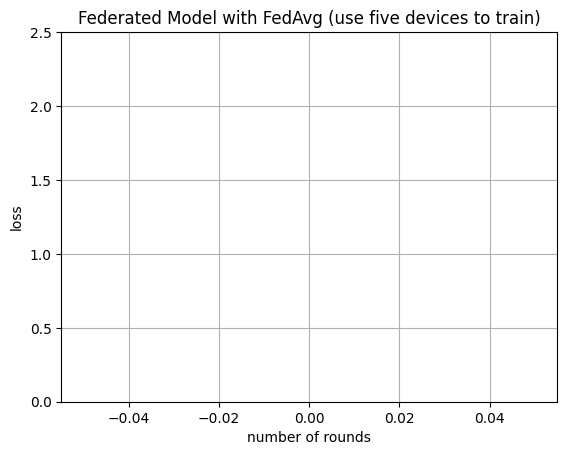

In [ ]:
'''
# train_loss_global
plt.plot(train_loss_global)
plt.xlabel('number of rounds')
plt.ylabel('loss')
plt.ylim((0, 2.5))
plt.grid()
plt.title('Federated Model with FedAvg (use five devices to train)')
plt.show()
'''

# Evaluation

In [22]:
client_models = []
for i in range(len(devices)):
  client_models.append(torch.load('D:/Amrita College/OneDrive - Amrita university/Semester 7/Codes/Final Year Project/models/clients/' + devices[i] + '.pt'))

In [23]:
from sklearn import metrics

In [31]:
def get_thresh(model, dataloader):

    model.eval()
    errs = []
    for batch in dataloader:
       for data in batch:
         mse = np.mean(np.power(data.float().cpu().detach().numpy() - model(data.float()).cpu().detach().numpy(), 2), axis=0)
         thresh = mse.mean() + mse.std()
         errs.append(thresh)
    thresh = sum(errs) / len(errs)
    return thresh

    #model.eval()
    #pred = global_model(tr_data).cpu().detach().numpy()
    #print(pred)
    #print(np.isnan(pred))
    #thresh = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
    #mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    #tr = np.sqrt(metrics.mean_squared_error(model(tr_data).cpu().detach().numpy(), tr_data.cpu().detach().numpy()))
    #tr = np.sqrt(mse)
    #return thresh

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
           TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
           FP += 1
        if y_actual[i] == y_pred[i] == 0:
           TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    prediction = []
    for i in mix_data:
      pred = model(i).cpu().detach().numpy()
      error = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
      if error > tr:
        prediction.append(1)
      else:
        prediction.append(0)

    mix_label_list = mix_label.tolist()

    TP,FP,TN,FN = perf_measure(mix_label_list, prediction)

    conf = [[TP, FN],[FP, TN]]
    print(conf)
    x_axis_label = ['abnormal', 'benign']
    y_axis_label = ['abnormal', 'benign']

    plt.figure()
    sns.heatmap(conf,xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16},fmt='g')

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100,
                                                                                                   precision,
                                                                                                   recall,
                                                                                                   F1score*100,
                                                                                                   TPR,
                                                                                                   FPR))

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [32]:
thresholds = {}
for i in range(len(devices)):
    model = client_models[i]
    dataloader = train_loader[devices[i]]
    thresholds[devices[i]] = get_thresh(model, dataloader)
print(thresholds)

In [27]:
thresholds_test = {}
for i in range(len(devices)):
    model = client_models[i]
    dataloader = test_loader[devices[i]]
    thresholds_test[devices[i]] = get_thresh(model, dataloader)
print(thresholds_test)

{'Bot.csv': 118621.74529157366, 'DDOS attack-HOIC.csv': 112753.84753964552, 'DDoS attacks-LOIC-HTTP.csv': 112470.24560005544, 'DoS attacks-Hulk.csv': 113943.95710699446, 'DoS attacks-SlowHTTPTest.csv': 118818.99211647727, 'FTP-BruteForce.csv': 118014.7209087171, 'Infilteration.csv': 115606.95802331349, 'SSH-Bruteforce.csv': 114871.43835034013}


In [26]:
len(thresholds)

8

In [27]:
devices

['Bot.csv',
 'DDOS attack-HOIC.csv',
 'DDoS attacks-LOIC-HTTP.csv',
 'DoS attacks-Hulk.csv',
 'DoS attacks-SlowHTTPTest.csv',
 'FTP-BruteForce.csv',
 'Infilteration.csv',
 'SSH-Bruteforce.csv']

In [28]:
test_loader

{'Bot.csv': <torch.utils.data.dataloader.DataLoader at 0x284a0253670>,
 'DDOS attack-HOIC.csv': <torch.utils.data.dataloader.DataLoader at 0x284fa4bd580>,
 'DDoS attacks-LOIC-HTTP.csv': <torch.utils.data.dataloader.DataLoader at 0x284fa4bdb50>,
 'DoS attacks-Hulk.csv': <torch.utils.data.dataloader.DataLoader at 0x284fa4bdd90>,
 'DoS attacks-SlowHTTPTest.csv': <torch.utils.data.dataloader.DataLoader at 0x284fa4bd700>,
 'FTP-BruteForce.csv': <torch.utils.data.dataloader.DataLoader at 0x284fa4bf520>,
 'Infilteration.csv': <torch.utils.data.dataloader.DataLoader at 0x284fa4bf4c0>,
 'SSH-Bruteforce.csv': <torch.utils.data.dataloader.DataLoader at 0x284fa4bf970>}

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

device_idx = {device: i for i, device in enumerate(devices)}


for device in devices:
  model = client_models[device_idx[device]]
  threshold = thresholds[device]
  test_set = test_loader[device]
  y_true = []
  y_pred = []
  for x in test_set:
    for data in x:
      print(data.shape)
      err = np.mean(np.power(data.float().cpu().detach().numpy() - model(data.float()).cpu().detach().numpy(), 2), axis=0)
      y_true.append(1)
      y_pred.append(1 if err <= threshold else 0)
  TP, FP, TN, FN = perf_measure(y_true, y_pred)
  conf_matrix = [[TP, FN], [FP, TN]]
  plt.figure()
  sns.heatmap(conf_matrix, annot=True, fmt="d")
  plt.title("Confusion Matrix for Client {}".format(device))
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

#   [['TP', 'FN']
#   ['FP', 'TN']]


torch.Size([75])


AxisError: axis 1 is out of bounds for array of dimension 1

C:\Users\adith\AppData\Local\Temp\ipykernel_22232\2495036086.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


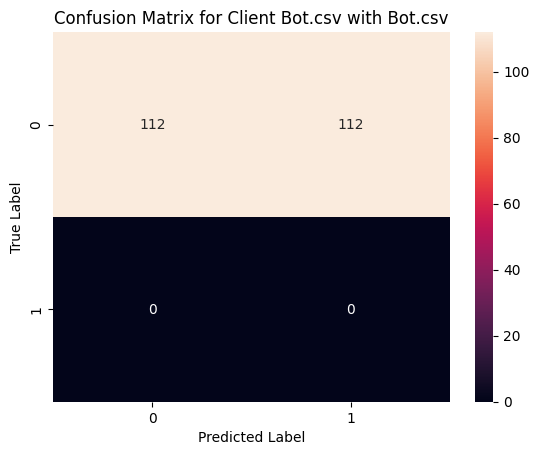

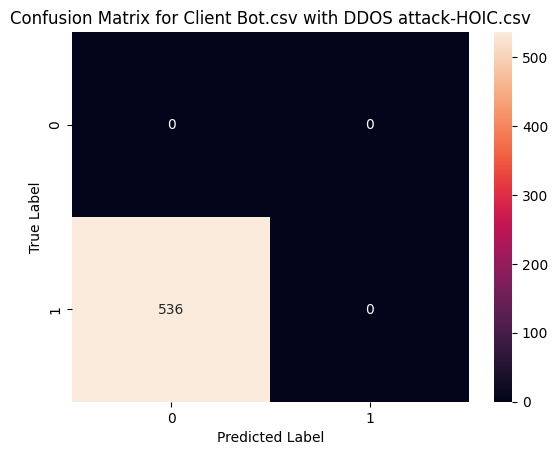

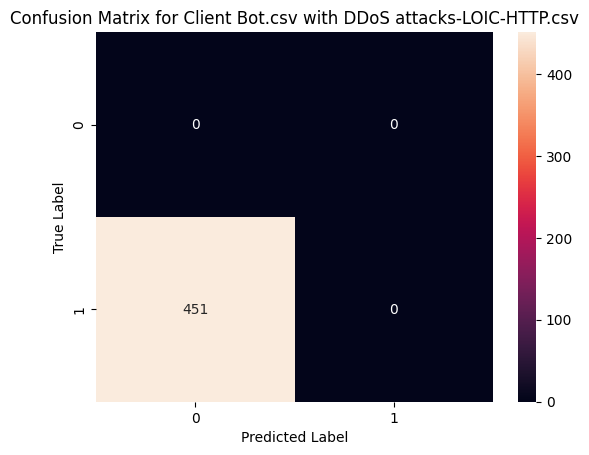

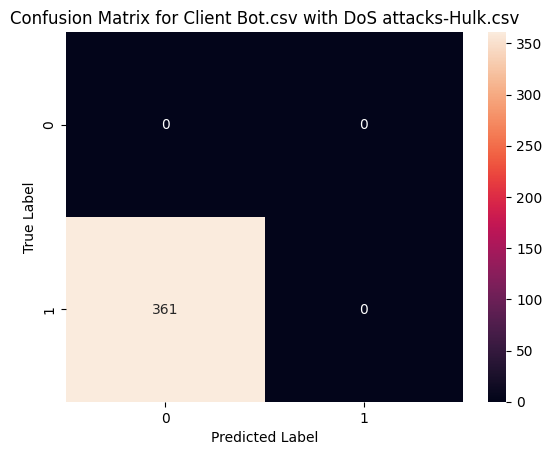

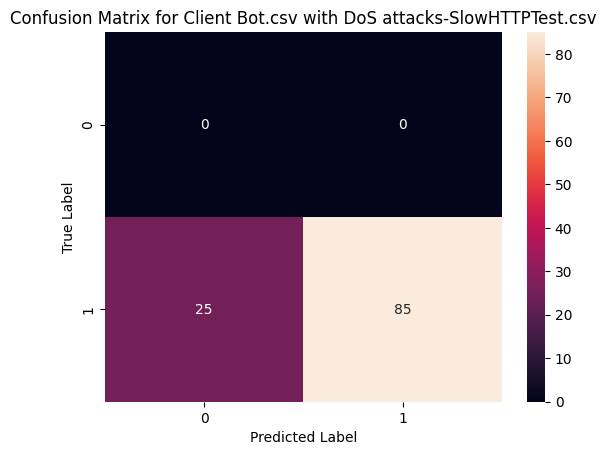

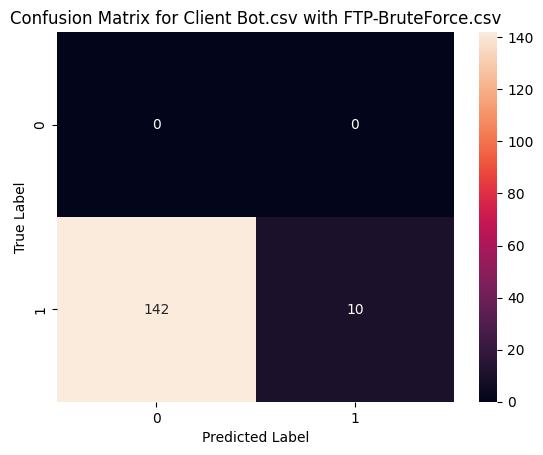

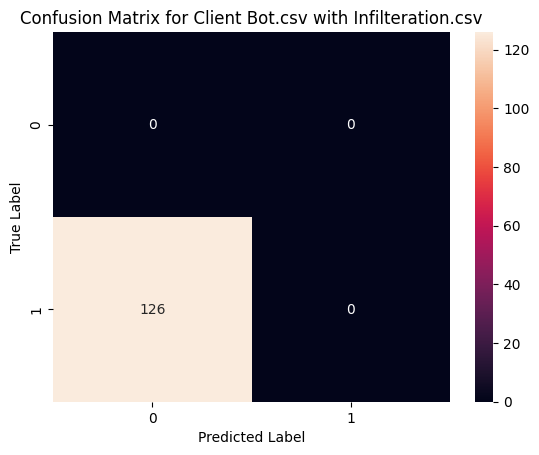

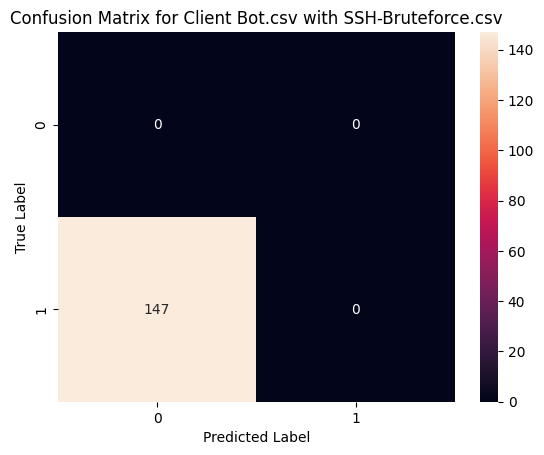

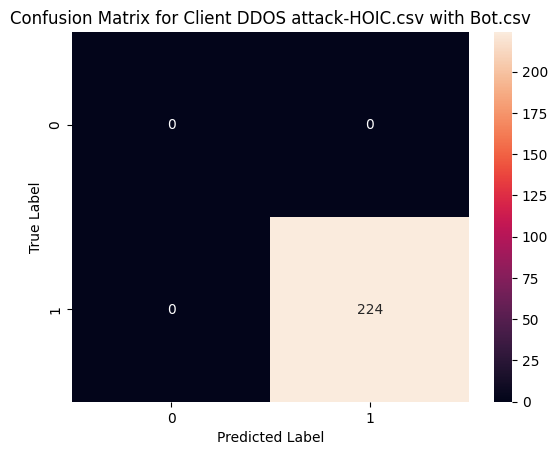

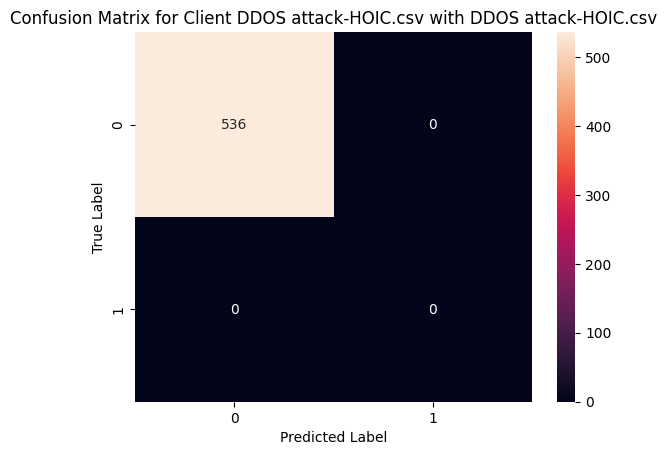

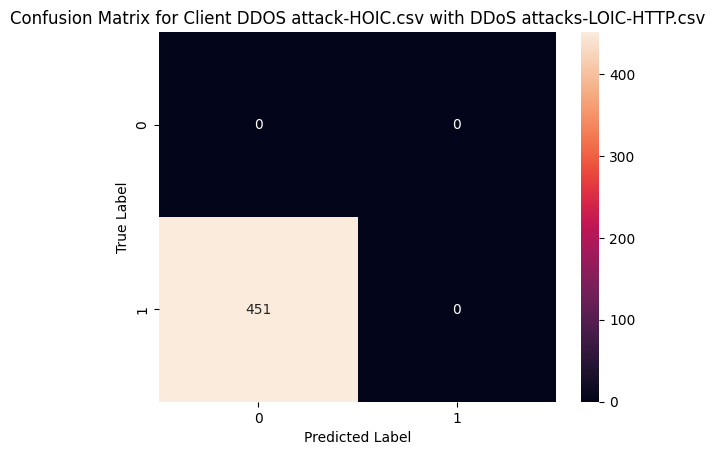

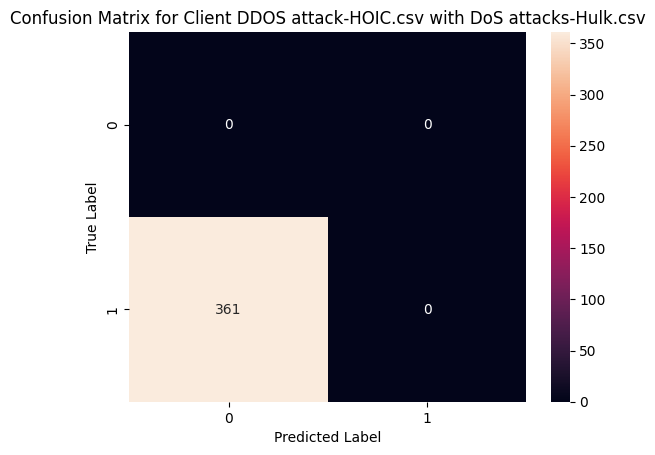

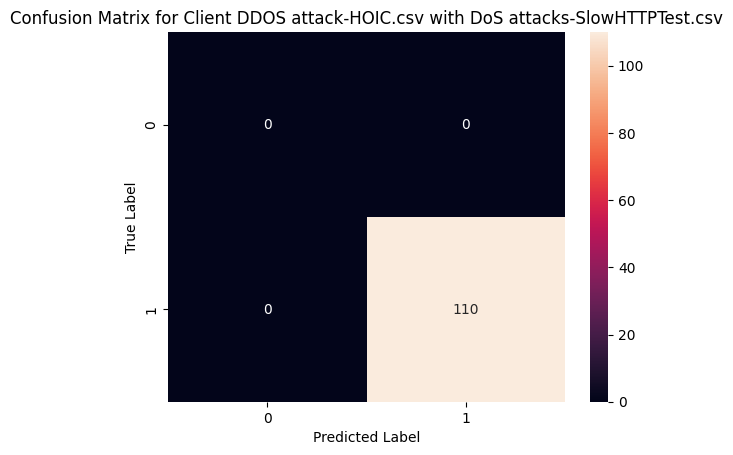

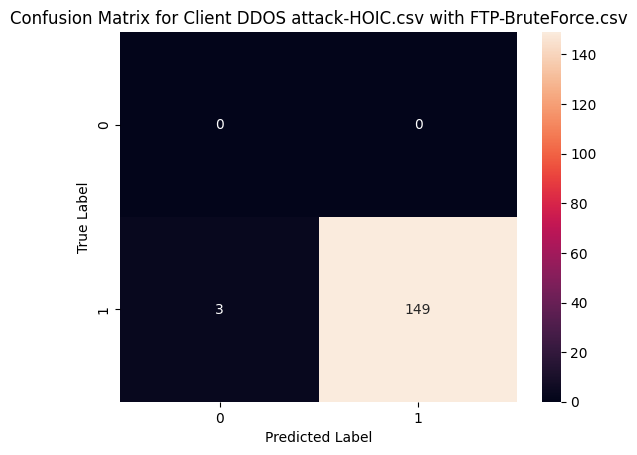

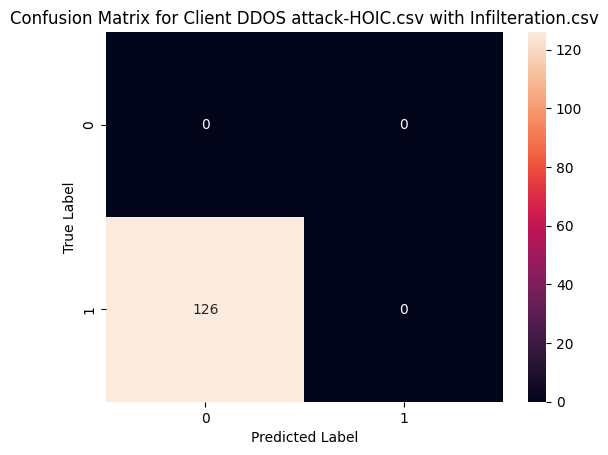

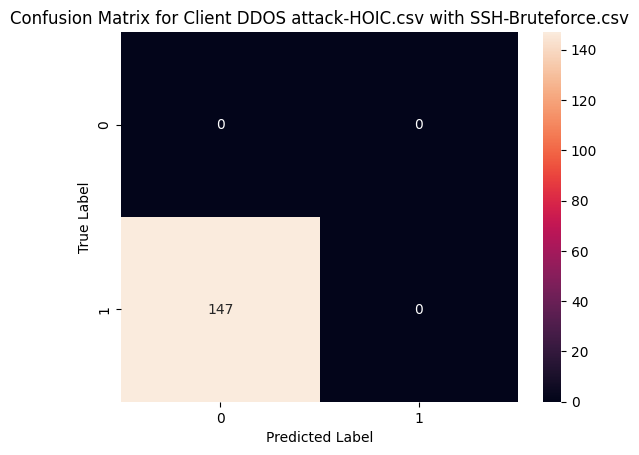

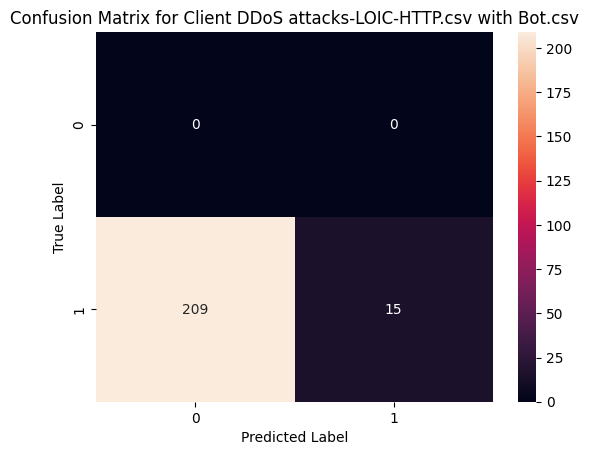

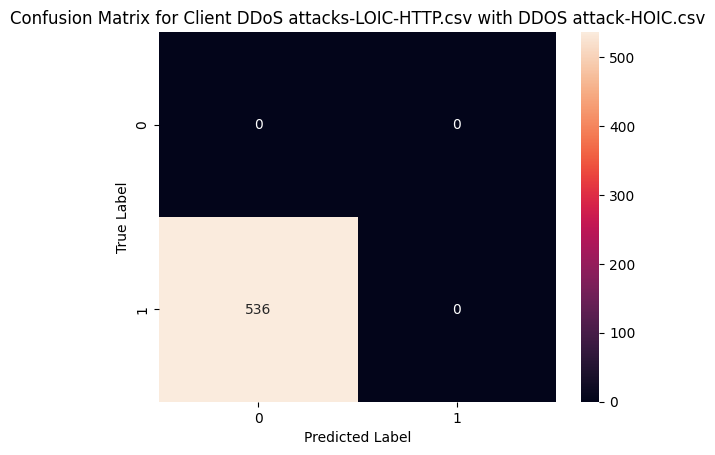

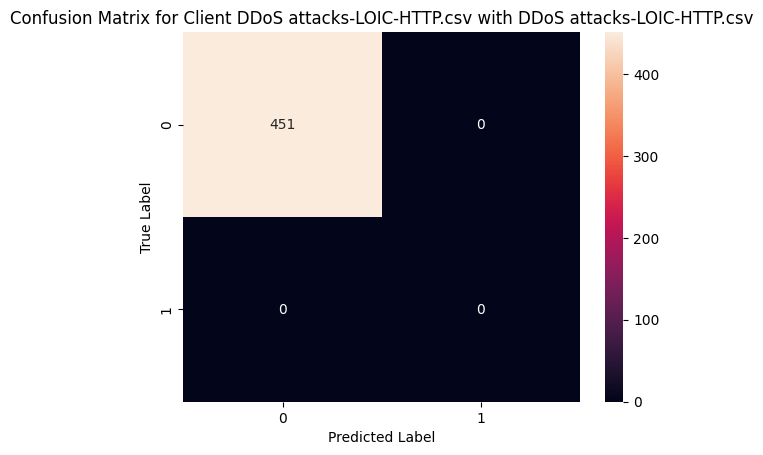

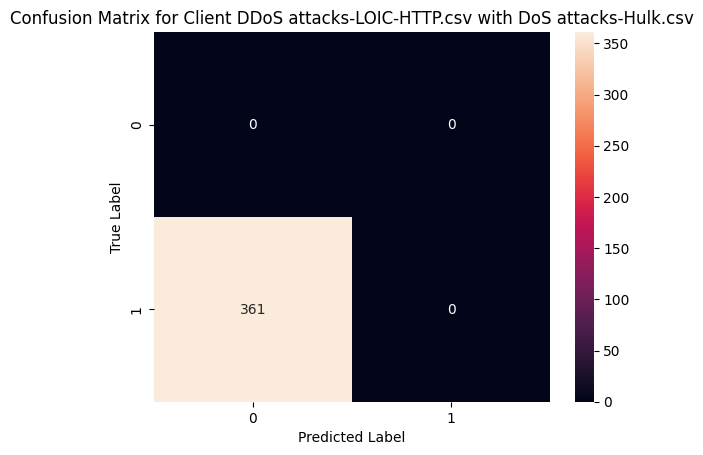

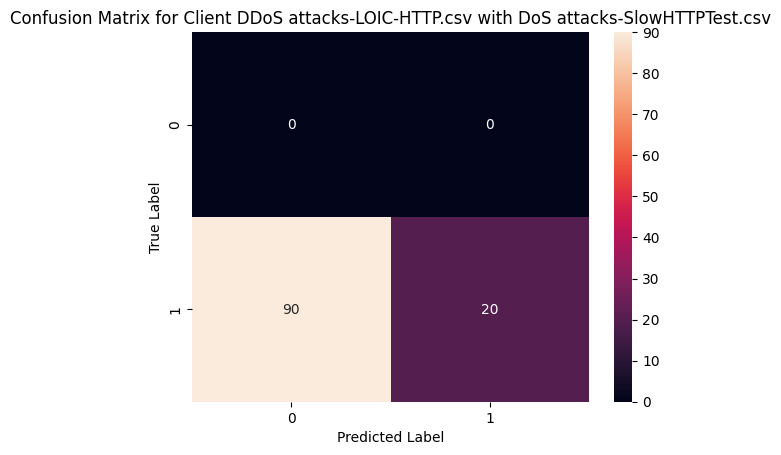

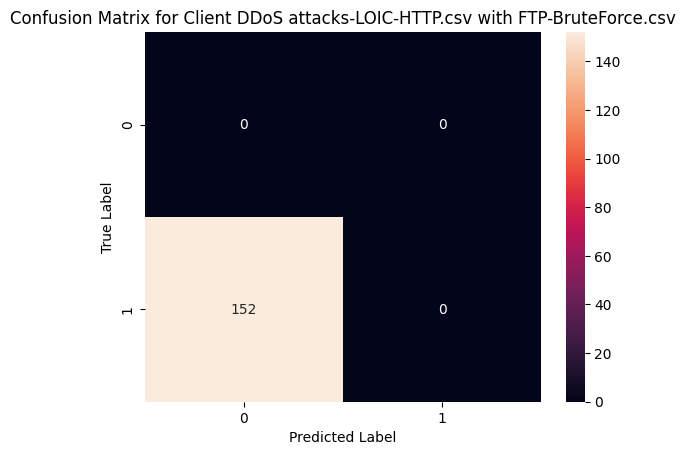

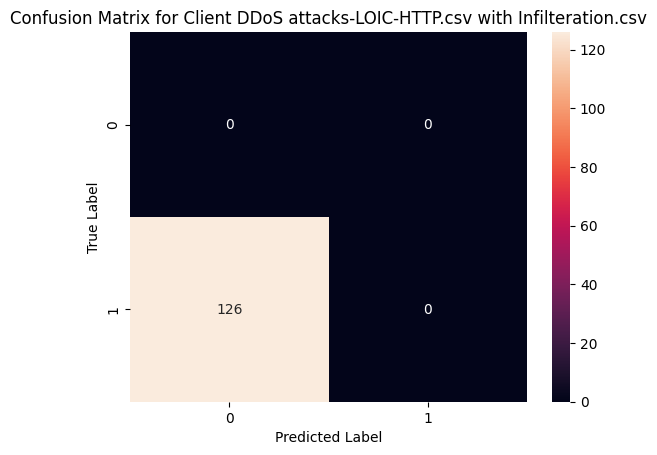

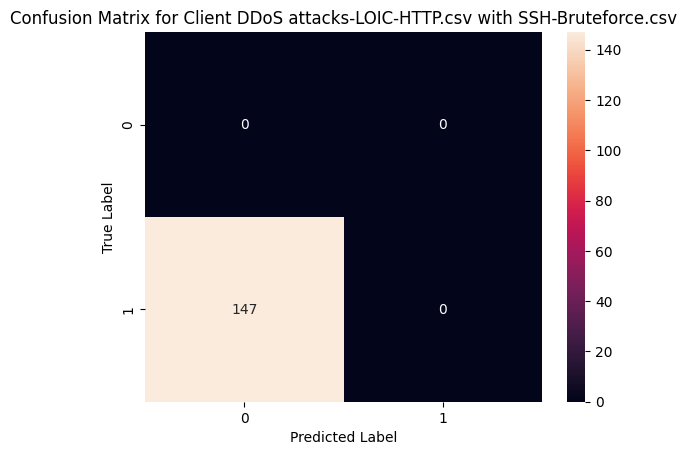

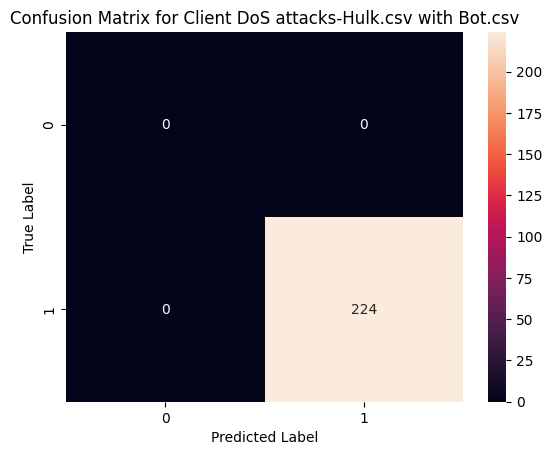

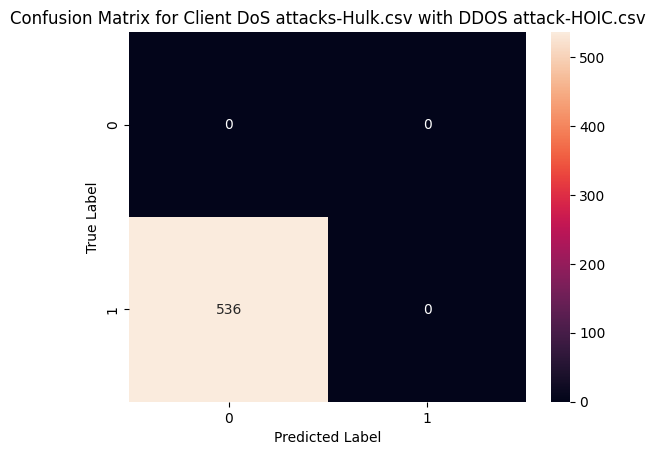

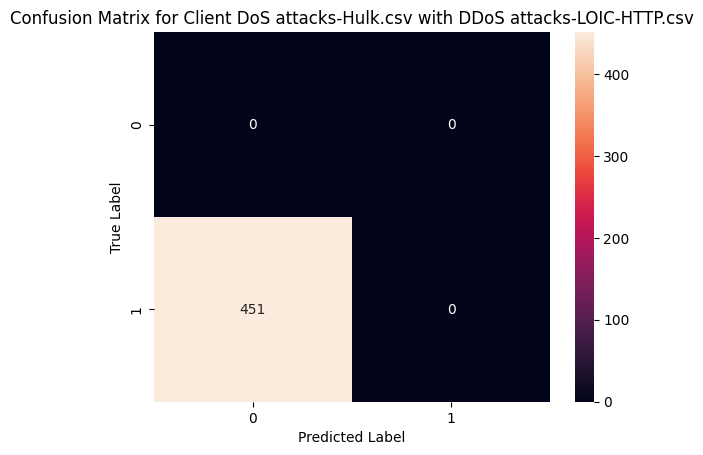

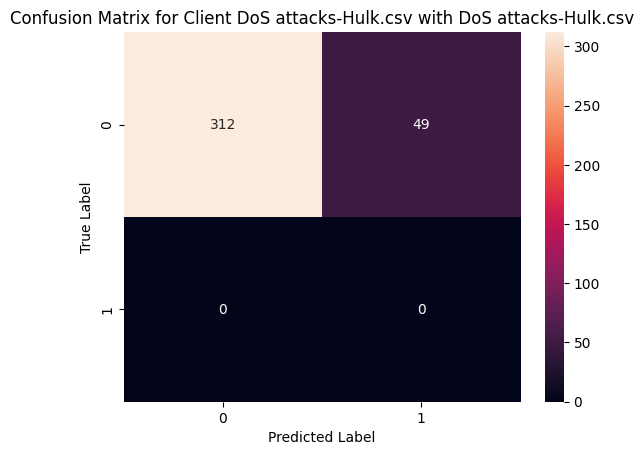

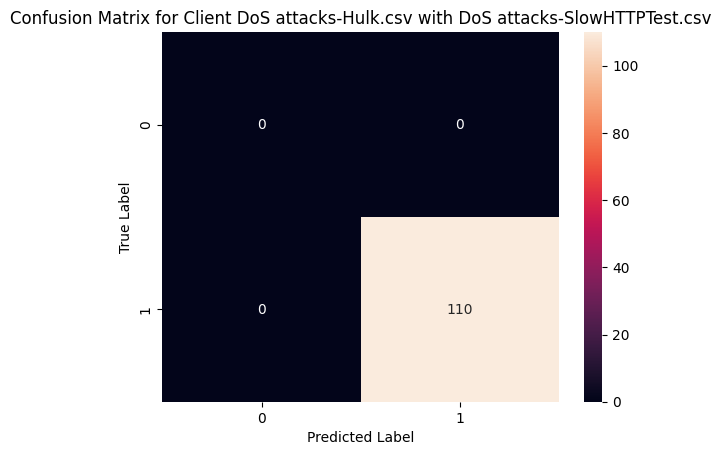

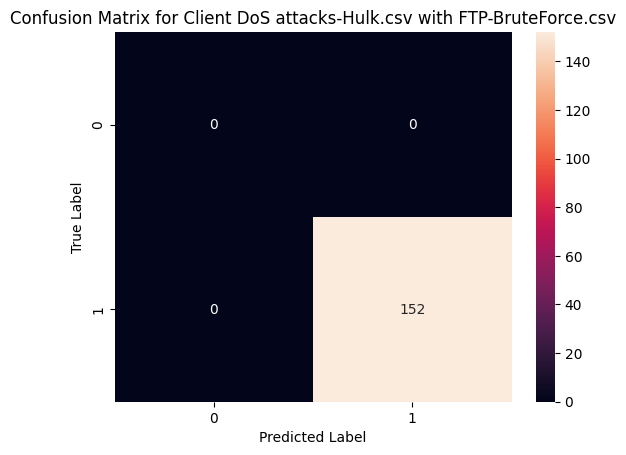

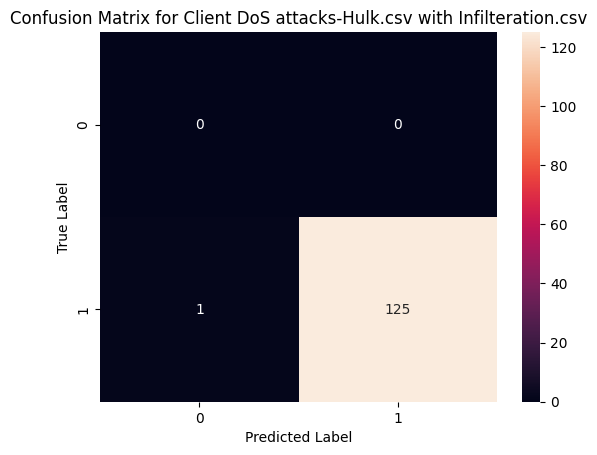

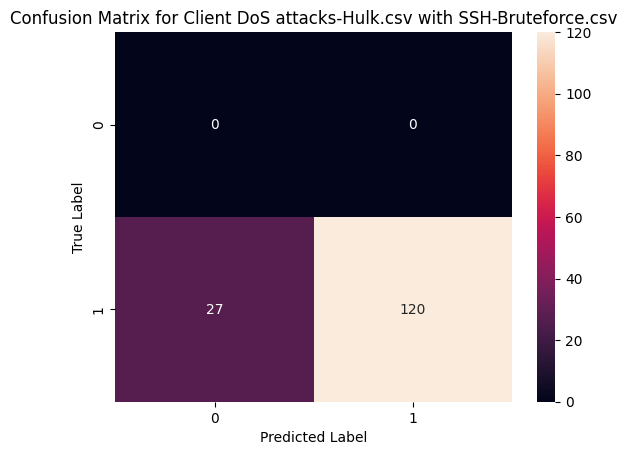

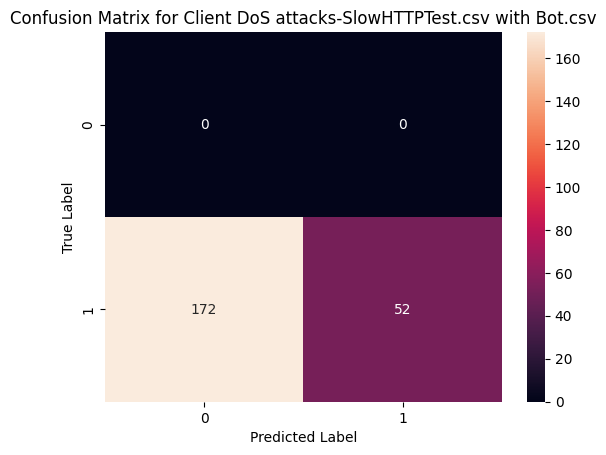

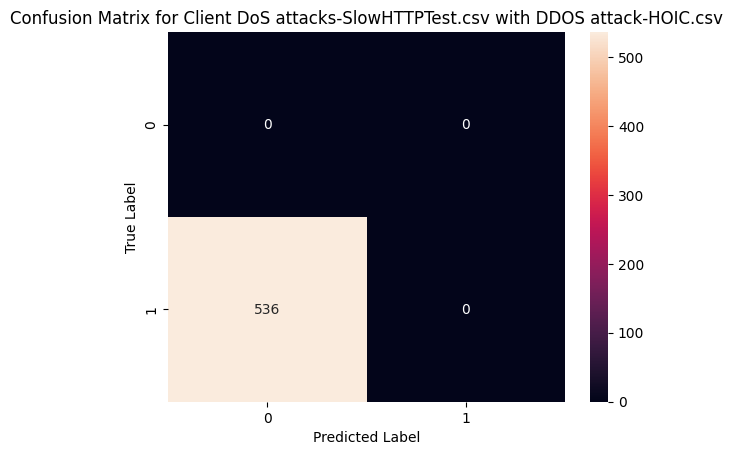

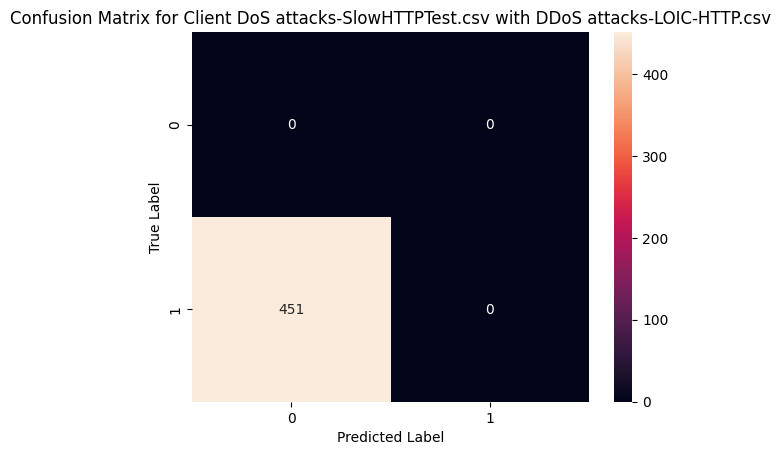

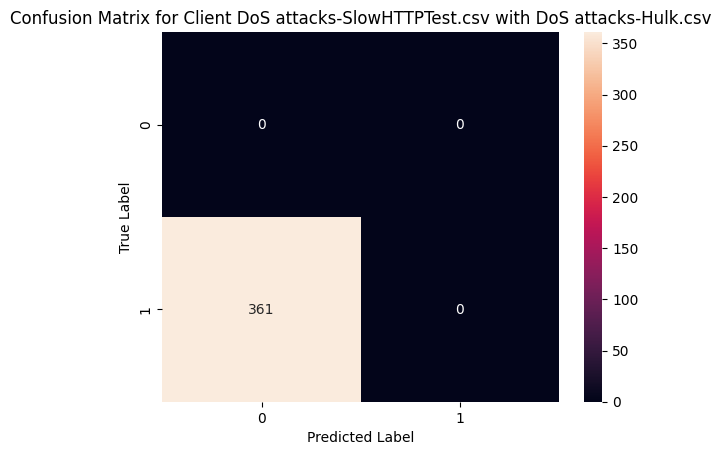

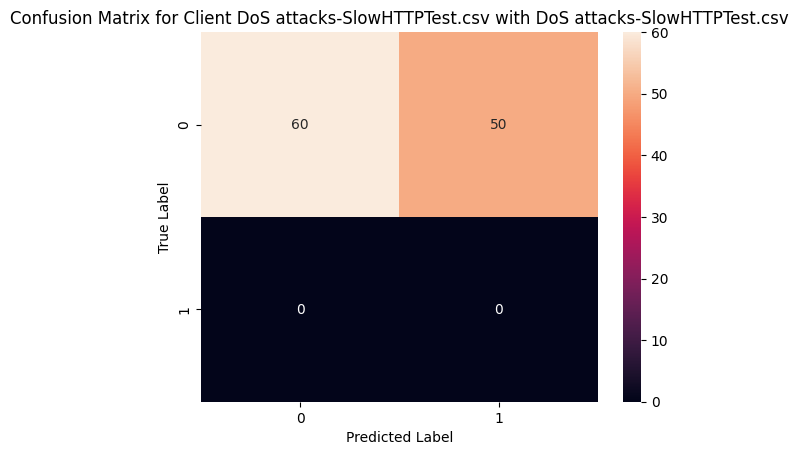

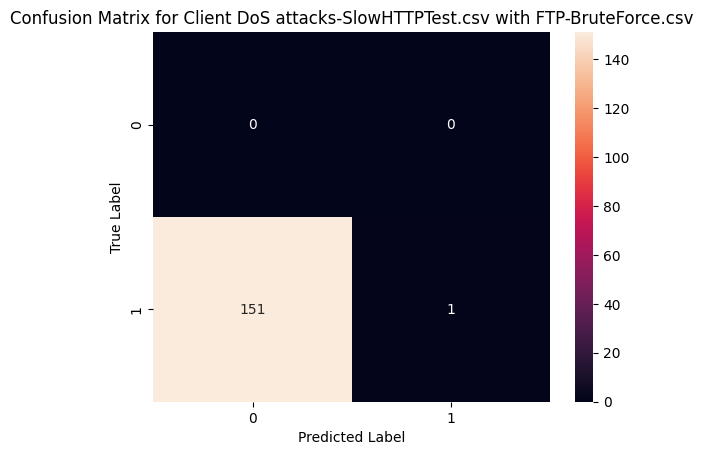

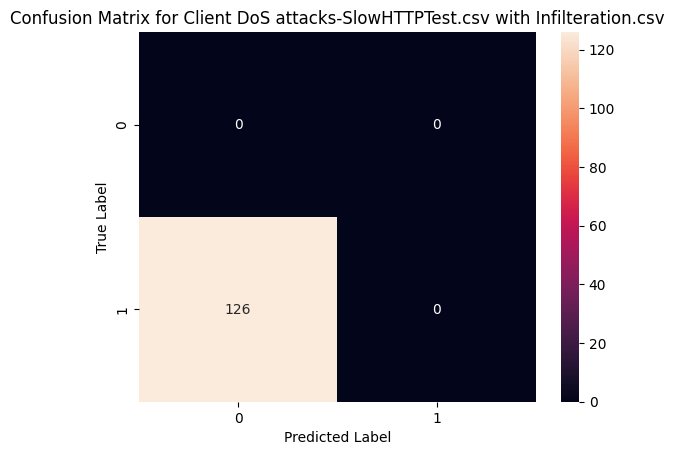

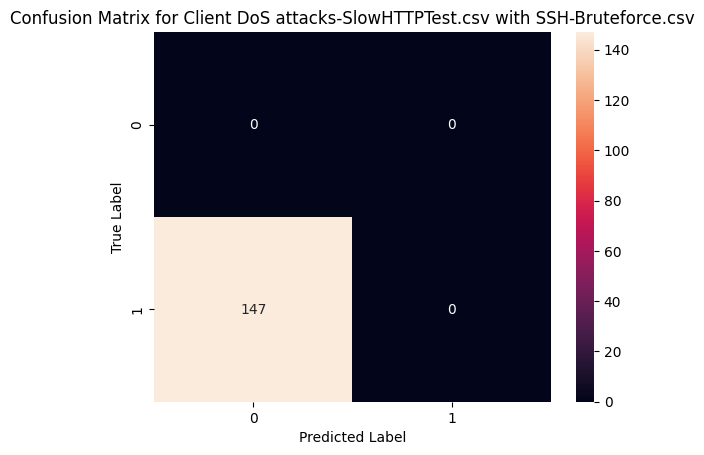

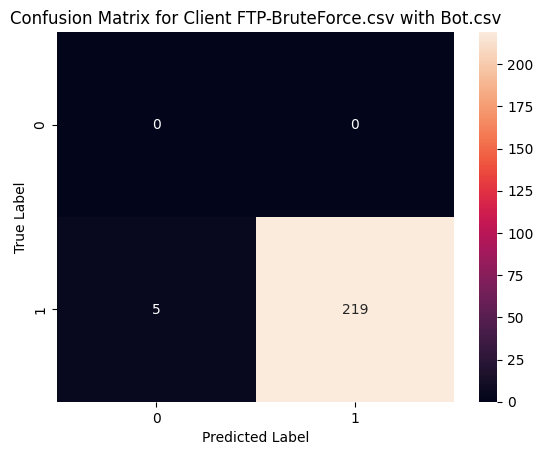

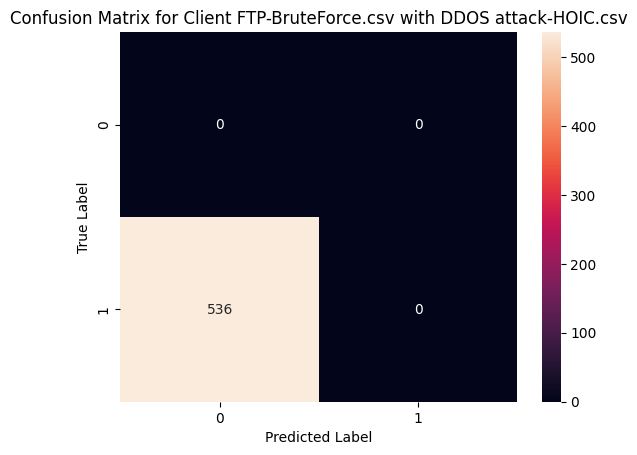

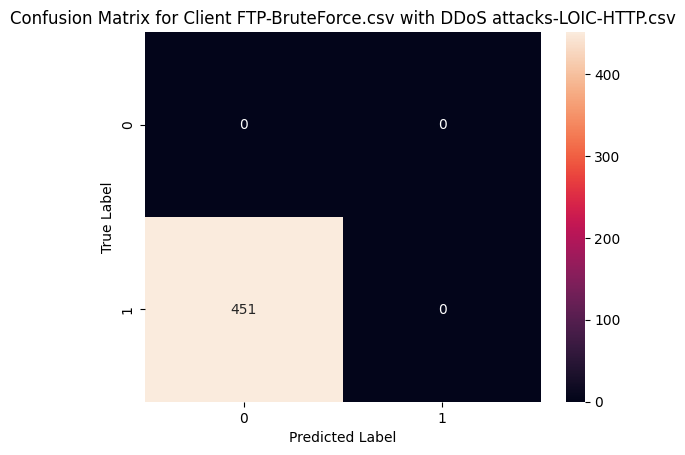

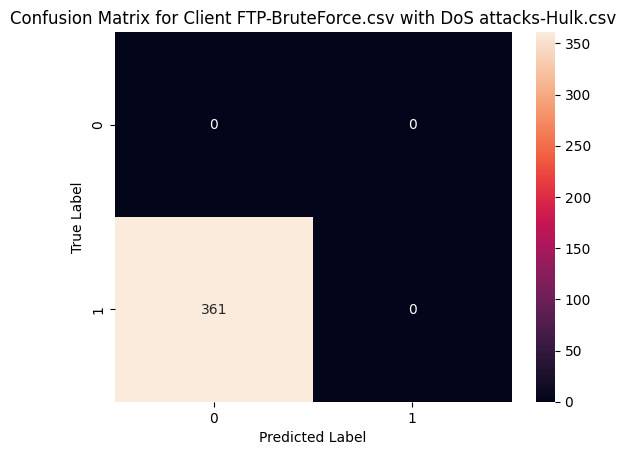

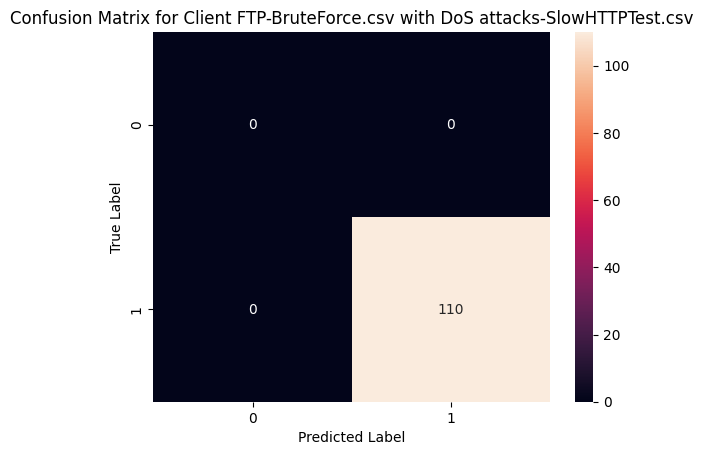

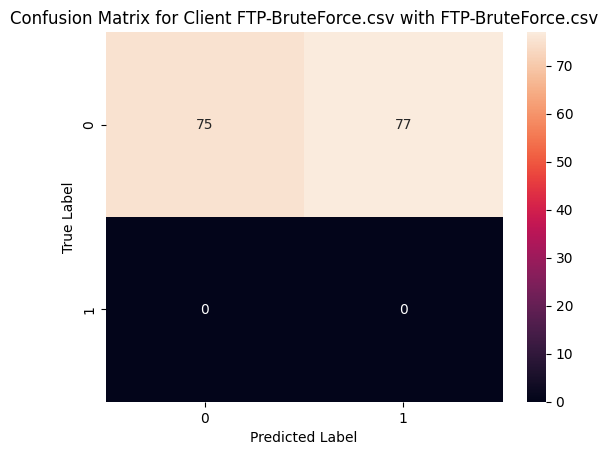

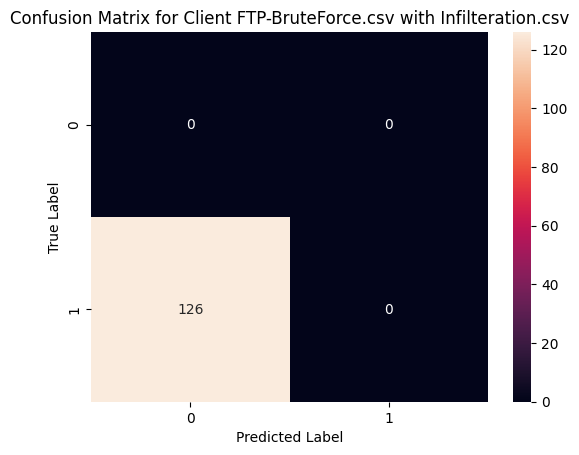

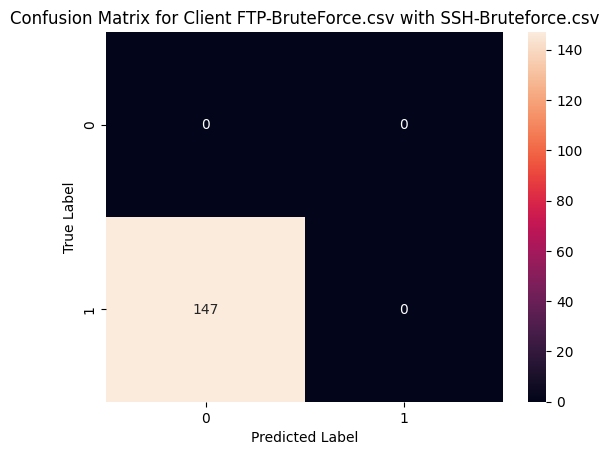

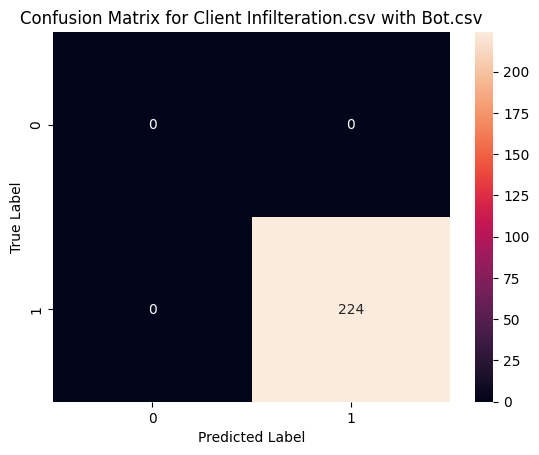

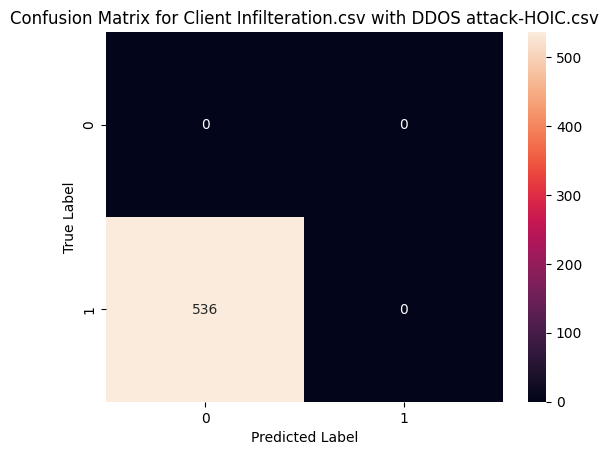

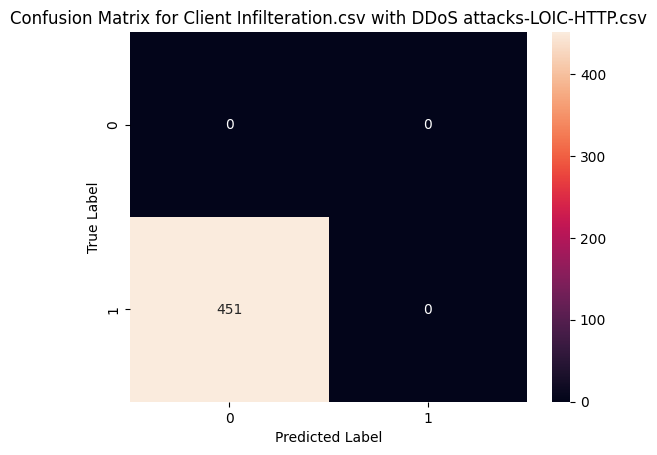

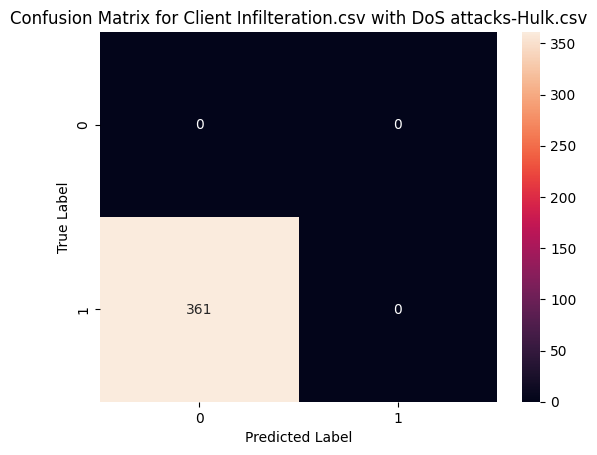

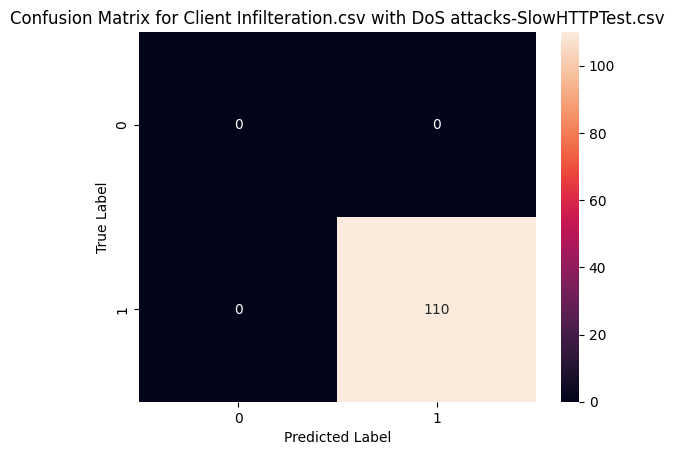

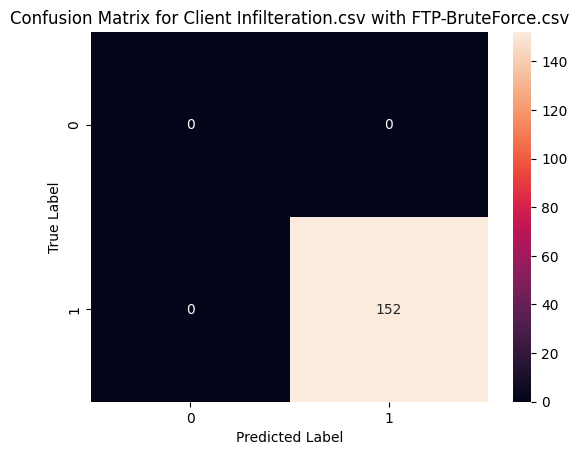

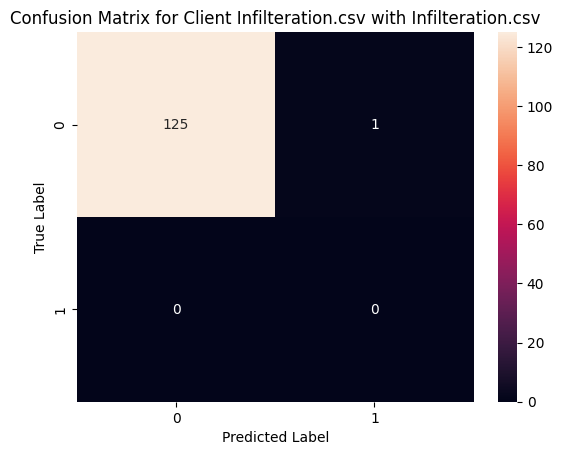

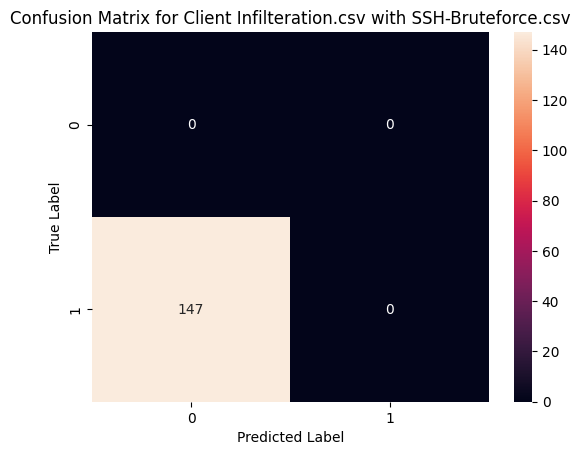

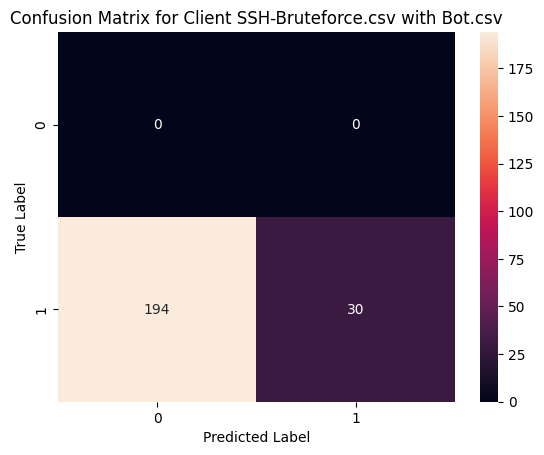

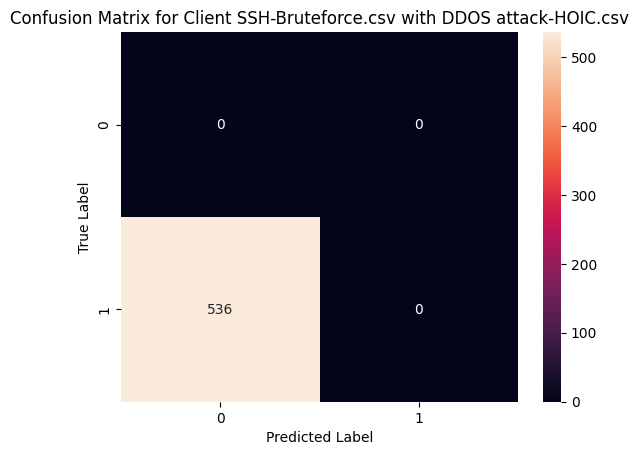

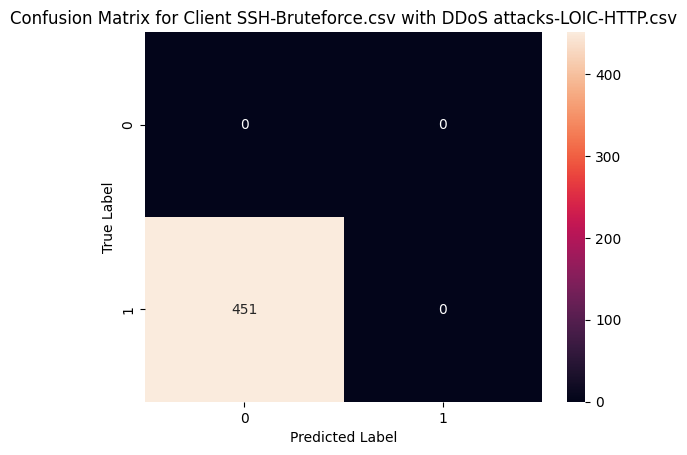

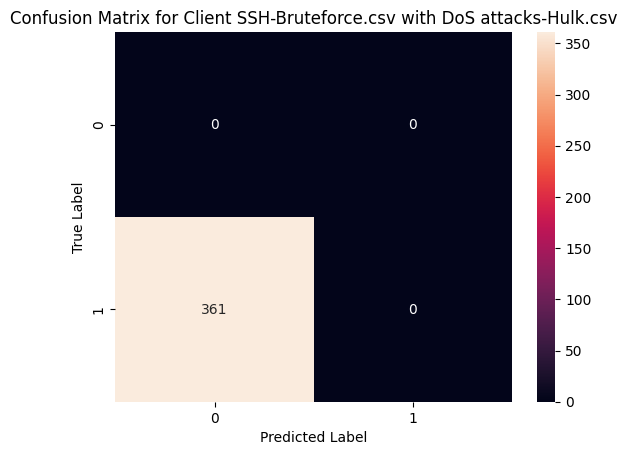

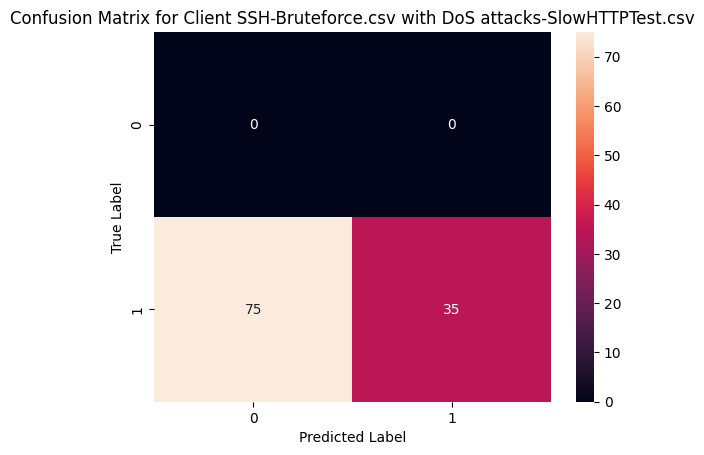

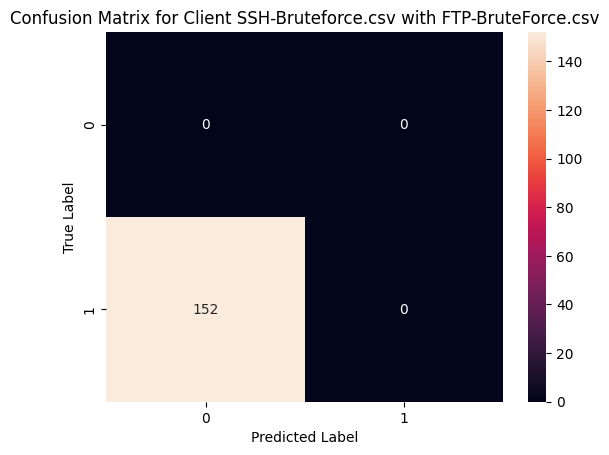

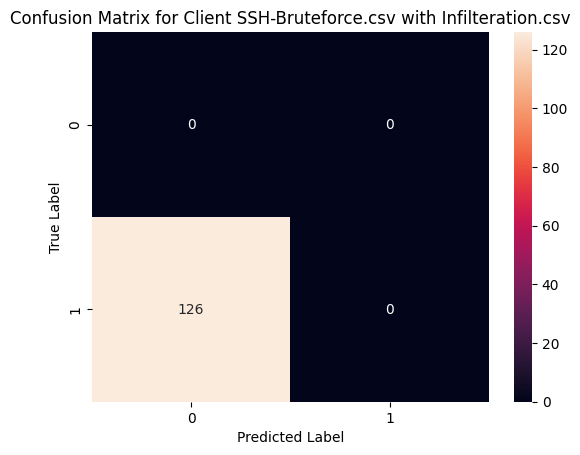

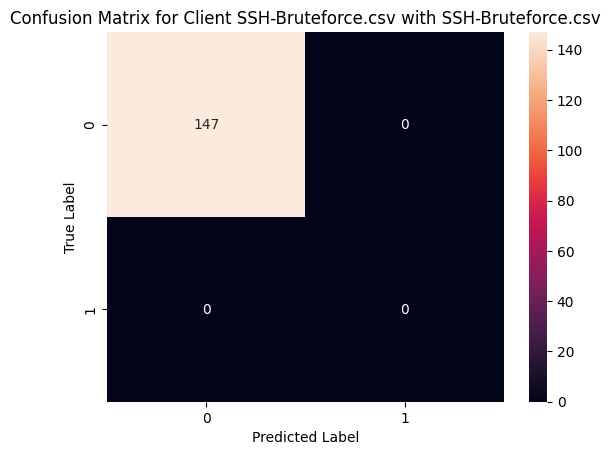

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  model = client_models[device_idx[device]]
  threshold = thresholds[device]
  for i in test_loader:
    test_set = test_loader[i]
    y_true = []
    y_pred = []
    for batch in test_set:
      for data in batch:
        err = np.mean(np.power(data.float().cpu().detach().numpy() - model(data.float()).cpu().detach().numpy(), 2), axis=0)
        if device == i:
          y_true.append(1)
          y_pred.append(1 if err <= threshold else 0)
        else:
          y_true.append(0)
          y_pred.append(0 if err <= threshold else 1)
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    conf_matrix = [[TP, FN], [FP, TN]]
    plt.figure() 
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix for Client " + str(device) +" with "+ str(i))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

#   [['TP', 'FN']
#   ['FP', 'TN']]

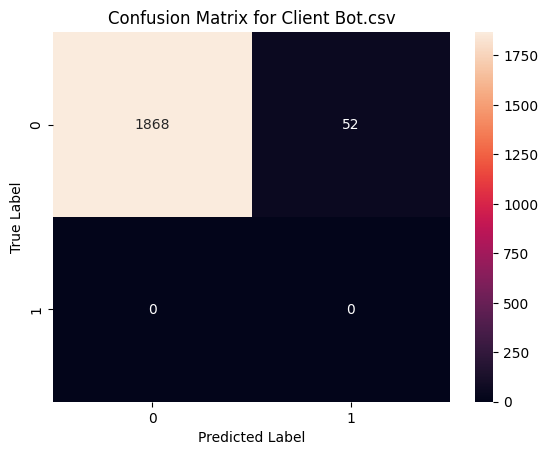

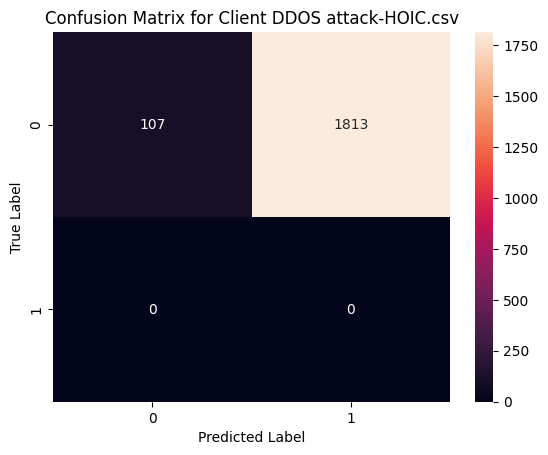

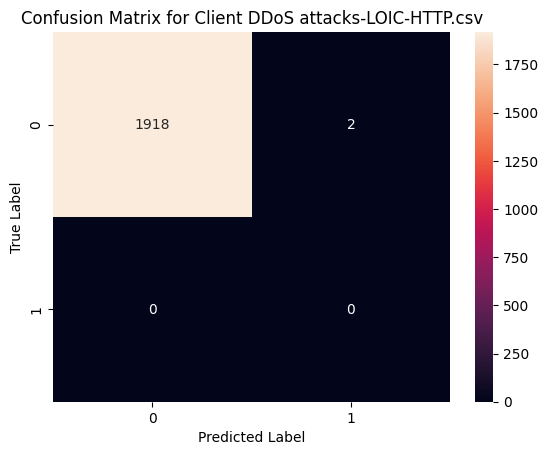

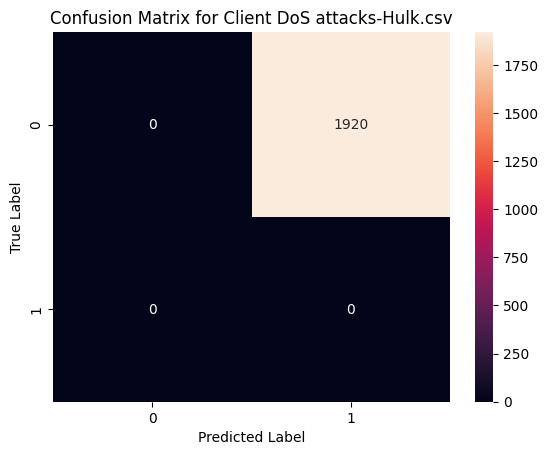

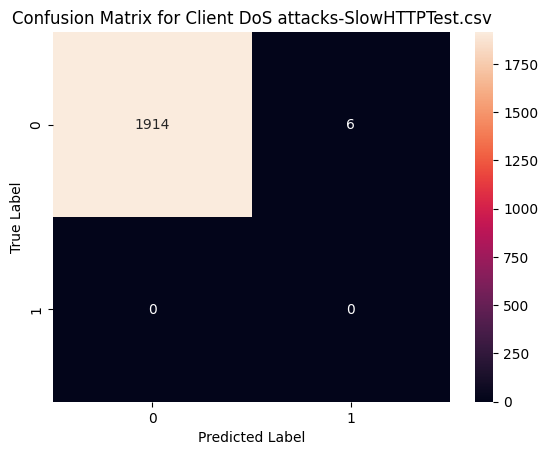

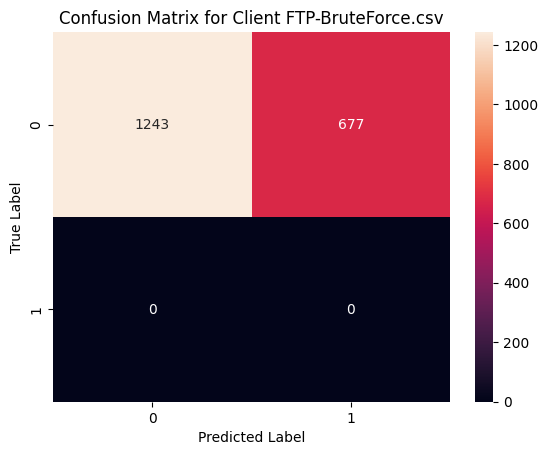

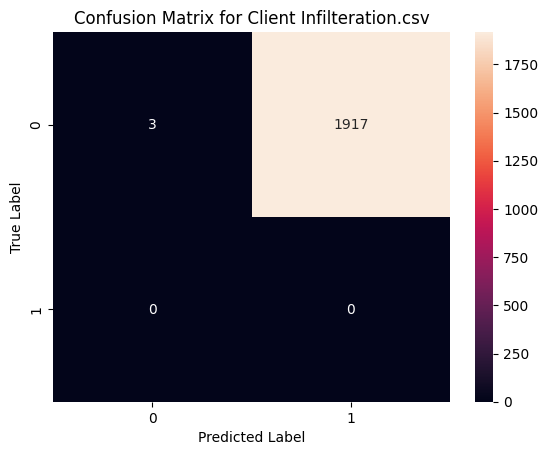

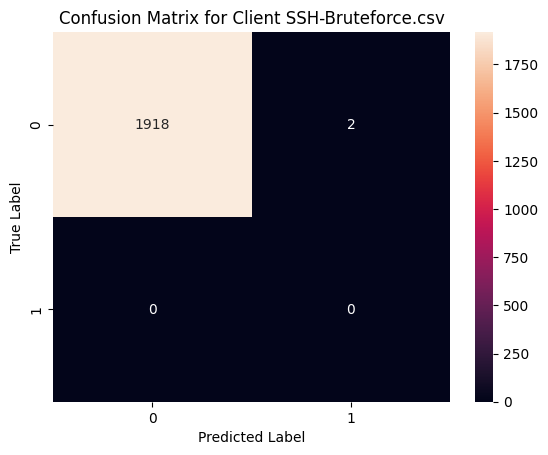

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

device_idx = {device: i for i, device in enumerate(devices)}


tp_dict = {}
fp_dict = {}
tn_dict = {}
fn_dict = {}

for device in devices:
  model = client_models[device_idx[device]]
  threshold = thresholds[device]
  y_true = []
  y_pred = []
  for batch in ben_loader:
    for data in batch:
      err = np.mean(np.power(data.float().cpu().detach().numpy() - model(data.float()).cpu().detach().numpy(), 2), axis=0)
      y_true.append(0)
      y_pred.append(0 if err <= threshold else 1)
  TP, FP, TN, FN = perf_measure(y_true, y_pred)
  tp_dict[device] = TP
  fp_dict[device] = FP
  tn_dict[device] = TN
  fn_dict[device] = FN
  conf_matrix = [[TP, FN], [FP, TN]]
  plt.figure() 
  sns.heatmap(conf_matrix, annot=True, fmt="d")
  plt.title("Confusion Matrix for Client {}".format(device))
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

#   [['TP', 'FN']
#   ['FP', 'TN']]


In [ ]:
# load model
global_model = torch.load('/content/gdrive/My Drive/models/alldataglobal.pt')                                        

# Test on client devices

In [ ]:
threshben.drop(['Label'], axis=1, inplace=True)

In [ ]:
threshben = torch.from_numpy(np.array(threshben)).float().to(device)

In [ ]:
print(threshben)

In [ ]:
tensor_data = torch.cat([batch for batch in train_loader['D1']], dim=0)

In [ ]:
predtrain = global_model(tensor_data).cpu().detach().numpy()
print(predtrain)

In [ ]:
pred = global_model(threshben).cpu().detach().numpy()
print(pred)

In [ ]:
thresh = get_thresh(global_model, threshben)

In [ ]:
thresh.shape

In [ ]:
thresh

In [ ]:
# use global model & device's TR
testset = torch.from_numpy(np.array(testset)).float().to(device)
print("D1: ")
get_mix_result(global_model, thresh, testset, testlabels)